In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit
from sklearn import linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD

In [2]:
train_directory = "data/train.csv"

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]

In [3]:
train.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.039014,-0.006501,-0.040607,0.044000,-0.011676,0.008798,0.086147,-0.009824,-0.036183,0.053425
duration,0.039014,1.000000,-0.097477,-0.045726,0.025395,-0.028857,0.022067,-0.036543,-0.033147,-0.046760,0.433596
campaign,-0.006501,-0.097477,1.000000,0.058314,-0.090741,0.177055,0.145429,0.007416,0.159980,0.162461,-0.079928
pdays,-0.040607,-0.045726,0.058314,1.000000,-0.590461,0.271116,0.046450,-0.093359,0.303687,0.390379,-0.344608
previous,0.044000,0.025395,-0.090741,-0.590461,1.000000,-0.409944,-0.141692,-0.054761,-0.458122,-0.520039,0.268134
emp.var.rate,-0.011676,-0.028857,0.177055,0.271116,-0.409944,1.000000,0.747513,0.219751,0.969968,0.892328,-0.259834
cons.price.idx,0.008798,0.022067,0.145429,0.046450,-0.141692,0.747513,1.000000,0.063948,0.645568,0.450870,-0.065774
cons.conf.idx,0.086147,-0.036543,0.007416,-0.093359,-0.054761,0.219751,0.063948,1.000000,0.300212,0.130593,0.034768
euribor3m,-0.009824,-0.033147,0.159980,0.303687,-0.458122,0.969968,0.645568,0.300212,1.000000,0.940434,-0.278375
nr.employed,-0.036183,-0.046760,0.162461,0.390379,-0.520039,0.892328,0.450870,0.130593,0.940434,1.000000,-0.332281


In [4]:

# exclude 'nr.employed' & 'euribor3m' 
# cause correlation between 
# 'nr.employed' & 'euribor3m' & 'emp.var.rate' is too HIGH (~.9)
train = train.drop((['nr.employed', 'euribor3m']), axis=1)

## Выбор факторов:
    1) Создать модель со всеми факторами
    2) Высчитать значимость факторов в модели
    3) На наиболее значимых факторах построить новую модель


In [5]:
# represent categorical columns to indicators
categorical_columns = [c for c in train.columns if train[c].dtype.name == 'object']
numerical_columns   = [c for c in train.columns if train[c].dtype.name != 'object']

full_train_cats = pd.get_dummies(train[categorical_columns])

train = pd.concat((train[numerical_columns], full_train_cats), axis=1)
train = pd.DataFrame(train, dtype=float)

In [6]:
X = train.drop(('y'), axis=1)
y = train['y']

In [7]:
classifier = RandomForestClassifier(n_estimators=100)

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, 
                                                                                     test_size = 0.2)

In [9]:
classifier.fit(train_data , train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
err_train = np.mean(train_labels != classifier.predict(train_data))
err_test = np.mean(test_labels != classifier.predict(test_data))
print(err_train, err_test)

0.0 0.09302325581395349


In [11]:
# get feature importences
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

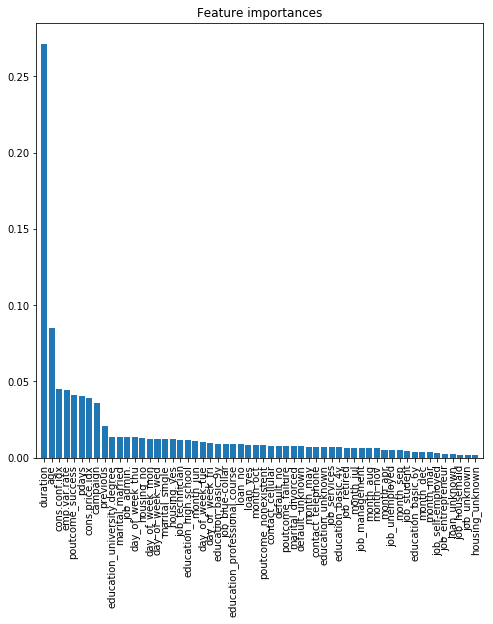

In [12]:
# model features impotances graphic
columns = X.columns
d_first = 58
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])
plt.show()

In [14]:
# choose important features
features_count = 10 # top from graphic "Feature importances"
selected_features = X.columns[indices[:features_count]]

In [15]:
# make new model
X_selected = train[selected_features]
train_data_selected, test_data_selected, train_labels_selected, test_labels_selected = train_test_split(X_selected, y, test_size = 0.2)

classifier_selected = RandomForestClassifier(n_estimators=100)
classifier_selected.fit(train_data_selected, train_labels_selected)

err_train_selected = np.mean(train_labels_selected != classifier_selected.predict(train_data_selected))
err_test_selected = np.mean(test_labels_selected != classifier_selected.predict(test_data_selected))

print(err_train_selected, err_test_selected)

0.0 0.06976744186046512


In [16]:
# new model roc_auc and cross_valid(sss)
pred_labels = classifier_selected.predict(test_data_selected)

roc_auc = metrics.roc_auc_score(test_labels_selected, pred_labels)
print("ROC AUC: ", roc_auc)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
scores = cross_validate(classifier_selected, X_selected, y=y, cv=sss)['test_score']

print("Cross validation avg(5): ", sum(scores)/5)

ROC AUC:  0.782051282051282
Cross validation avg(5):  0.8979844961240311


In [17]:
# full model roc_auc and cross_valid(sss)
pred_labels_full = classifier.predict(test_data)

roc_auc_full = metrics.roc_auc_score(test_labels, pred_labels_full)
print("ROC AUC: ", roc_auc_full)

sss_full = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
scores_full = cross_validate(classifier, X, y=y, cv=sss_full)['test_score']

print("Cross validation avg(5): ", sum(scores_full)/5)

ROC AUC:  0.6622673065735893
Cross validation avg(5):  0.9001550387596898


### Действия:
    1) Избавиться полностью/частично от выбросов

    2) Поэкспериментировать с глубиной, количеством деревьев  и т. д.

    3) Узнать больше о выборе и формировании факторов для модели(например, в pdays 95%+ значений = 999, выглядит подозрительно, но я не знаю, что с этим делать)